In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 선수카드의 Overall 예측 모델

## 목차

1. 기획
2. 데이터 전처리
3. 분석
4. 학습

# 1. 기획
## 소개
피파는 세계에서 가장 유명한 축구게임이다. 게임에는 실제 선수의 능력치를 기반하여 만들어진 선수카드라는 것이 존재하며 각 카드의 종합 점수인 Overall 이라는 점수가 있다. Overall은 선수의 능력치와 유명도에 따라 점수가 매겨진다.
(아래 카드의 Overall은 93이다.)
<div>
<img src="https://media.contentapi.ea.com/content/dam/ea/fifa/fifa-21/ratings-collective/common/news/player-items/best-wingers/01-fifa21-golditems-messi.png.adapt.crop16x9.652w.png" width="20%" height="7%" />
</div>

## 목표
이번 기계학습의 목표는 선수들의 데이터를 분석하여 선수카드의 Overall을 예측하는 회귀 모델을 만드는 것이다.  
Overall 점수를 정답 label로 선택한 이유는 선수의 능력치와 정보를 평가하여 요악한 총 점수가 Overall이기 때문이다. 따라서 주어진 정보를 분석하고 처리하면 충분히 예측 가능하다고 생각했기 때문에 Overall을 정답 label로 선정하고 해당 문제를 제시하였다. 

# 2. 데이터 전처리
## 2-1. 수집
모델 학습을 위해 kaggle 사이트에서 제공하는 fifa21 complete player dataset을 사용하였다.     
데이터는 총 18944개의 선수카드에 대한 다양한 정보를 제공한다.  
https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset/version/1?select=players_21.csv

## 2-2. 데이터 read 및 정답 label 검사
106개의 columns으로 데이터셋이 구성되어 있다.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

# 파일 읽어온 후 데이터 프레임으로 변환(시각적 효과와 일관성을 위해)
fifa = pd.read_csv('/content/drive/MyDrive/3학년2학기/기계학습론/assignment1/players_21.csv')
print("(선수,특성) 개수 : {}".format(fifa.shape))
fifa.head()

(선수,특성) 개수 : (18944, 106)


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,...,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,...,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,...,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,...,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...",LW,10.0,NaN,2017-08-03,2022.0,NaN,NaN,91.0,85.0,86.0,94.0,36.0,59.0,NaN,...,51,36,87,90,92,93,NaN,30,29,9,9,15,15,11,84+3,84+3,84+3,90+0,89+0,89+0,89+0,90+0,90+1,90+1,90+1,90+1,83+3,83+3,83+3,90+1,67+3,62+3,62+3,62+3,67+3,62+3,49+3,49+3,49+3,62+3


In [49]:
fifa.describe()

,sofifa_id,age,height_cm,weight_kg,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18944.000000,18944.000000,18944.000000,18944.000000,18719.000000,18944.000000,18944.000000,1.894400e+04,18944.000000,18944.000000,18944.000000,18944.000000,1.794900e+04,18719.000000,18719.000000,1127.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,16861.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,0.0,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000,18944.000000
mean,226242.402872,25.225823,181.190773,75.016892,1.357070,65.677787,71.086729,2.224813e+06,8675.852513,1.091850,2.936603,2.363017,4.296353e+06,20.589668,2021.983332,12.029281,67.668110,52.274954,57.139434,62.455430,51.316292,64.458988,65.164186,62.889102,61.719635,66.108017,37.203553,63.171867,49.612859,45.796083,51.874578,58.705448,42.669552,55.546400,47.187289,42.356155,52.653030,58.482791,64.285103,64.326489,63.333193,61.609428,63.918549,57.752798,64.590530,62.596020,64.742927,46.758763,55.488862,46.250000,50.255807,53.828231,48.050412,57.978674,NaN,47.581767,45.546505,16.446052,16.236486,16.103357,16.225982,16.551309
std,27171.091056,4.697354,6.825672,7.057140,0.739327,7.002278,6.109985,5.102486e+06,19654.774894,0.361841,0.667132,0.766469,1.005968e+07,17.057568,1.260426,6.674627,10.984862,13.991421,10.273655,10.048706,16.405179,9.746706,7.710474,7.328945,7.575184,8.126601,10.714523,8.565969,18.153057,19.592269,17.321709,14.572383,17.661569,18.787112,18.231204,17.239561,15.205281,16.598040,14.926452,14.689422,14.625189,9.112954,14.075215,13.330631,11.888479,15.878793,12.519775,19.305319,17.203045,20.738106,19.443738,13.724072,15.671721,12.118390,NaN,21.402461,20.953997,17.577332,16.845480,16.519399,17.017341,17.878121
min,41.000000,16.000000,155.000000,50.000000,1.000000,47.000000,47.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,9.000000e+03,1.000000,2020.000000,1.000000,25.000000,16.000000,25.000000,25.000000,15.000000,28.000000,45.000000,43.000000,35.000000,44.000000,12.000000,38.000000,6.000000,3.000000,5.000000,7.000000,3.000000,5.000000,4.000000,5.000000,5.000000,5.000000,13.000000,12.000000,14.000000,24.000000,12.000000,18.000000,15.000000,12.000000,16.000000,4.000000,9.000000,3.000000,2.000000,9.000000,6.000000,12.000000,NaN,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,210030.500000,21.000000,176.000000,70.000000,1.000000,61.000000,67.000000,3.000000e+05,1000.000000,1.000000,3.000000,2.000000,5.250000e+05,9.000000,2021.000000,6.000000,62.000000,42.000000,50.000000,57.000000,36.000000,58.000000,60.000000,58.000000,57.000000,60.000000,28.000000,57.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,35.000000,31.000000

모델이 예측할 정답 label인 ovearll을 검사해보았다. 0~100까지의 값이고 실제 데이터중 가장 높은 값은 93, 가장 낮은 값은 47이다.  
선수들의 overall은 분포는 정규 분포형과 유사한 형태이다.

count    18944.000000
mean        65.677787
std          7.002278
min         47.000000
25%         61.000000
50%         66.000000
75%         70.000000
max         93.000000
Name: overall, dtype: float64


Text(0.5, 0, 'Overall rating')

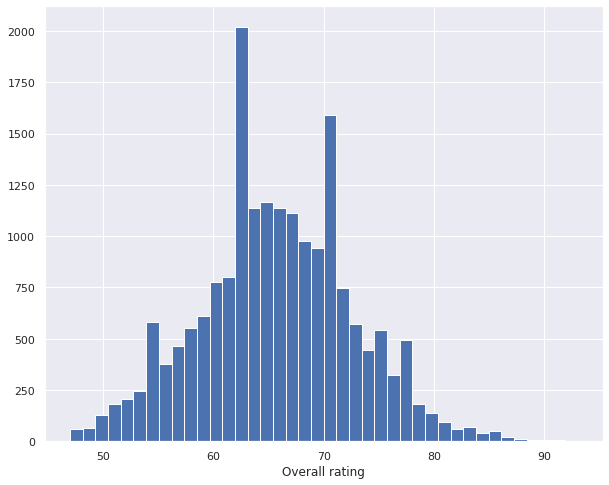

In [50]:
print(fifa['overall'].describe())
sns.set(rc={'figure.figsize': (10,8)})
plt.hist(fifa['overall'],bins=40)
plt.xlabel("Overall rating")

## 2-3. 첫번째 correlation heatmap 분석
선수마다 이름,나이,신장,능력치,포지션 등등 여러가지 features가 있다. 특징들간의 관계를 표현하기 위해 상관 분석을 진행하였다.



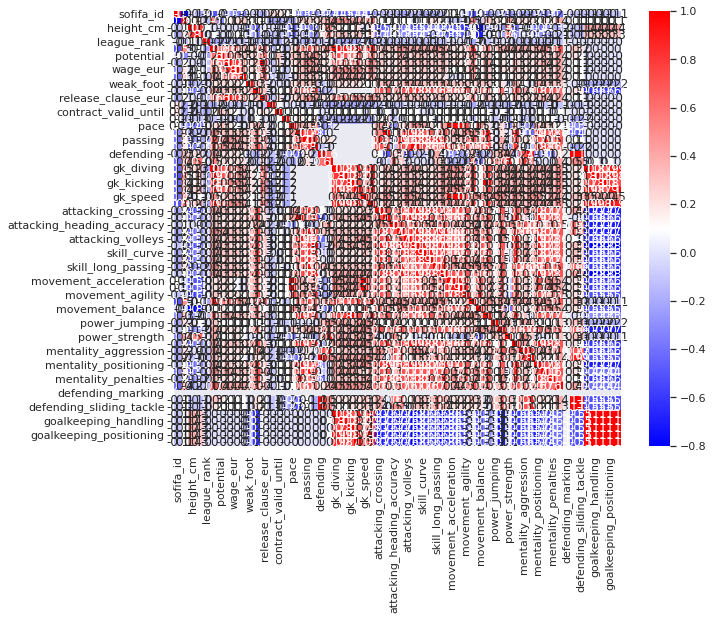

In [51]:
correlation_matrix = fifa.corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True, cmap="bwr")

현재 columns가 너무 많기 떄문에 제대로된 상관관계 분석이 되지않았다.  유효한 의미를 가지는 분석을 얻기 위해 선수들에 대한 정보를 일부 제거 하는 것이 필요하다 판단했다.

## 2-4. columns 제거 - 1 

In [52]:
# 생략없이 출력
pd.set_option('display.max_seq_items',None)
fifa.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name',
       'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur',
       'player_positions', 'preferred_foot', 'international_reputation',
       'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'team_position',
       'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until',
       'nation_position', 'nation_jersey_number', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'player_traits', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 

column들중 선수카드의 overall 영향을 주지 않는다고 판단되거나(이름, id, 사진 유무..) 수치화하기 어려운(생일, 키, 몸무게, 소속 팀명, 소속 리그명...) columns는 제거하였다.

In [53]:
fifa1 = fifa.drop(['sofifa_id','player_url','short_name','long_name','dob','height_cm', 'weight_kg','real_face',
                   'ls', 'st', 'rs','lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
                  'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb','rcb', 'rb'
                  ,'joined','contract_valid_until','club_name','league_name','team_jersey_number','body_type',
],axis=1)

## 2-5. columns 제거 - 2 
### 결측값을 통한 제거
모든 선수들이 모든 columns에 대한 정보를 가지고 있지 않기 때문에 결측값을 분석하여 columns을 제거하였다.  
columns 마다의 null값들의 개수를 구해 히스토그램으로 표현해보았다.  
<!-- 첫번째 히스토그램은 null 값이 전체 데이터셋에 절반 이상을(null value 9472 ~18944) 차지하는 columns을 의미한다.  
두번째 히스토그램은 null 값이 전체 데이터셋에 절반 이하의(null value 1 ~ 9472) 차지하는 columns를 의미한다. -->

league_rank : 225
release_clause_eur : 995
player_tags : 17536
team_position : 225
loaned_from : 18186
nation_position : 17817
nation_jersey_number : 17817
pace : 2083
shooting : 2083
passing : 2083
dribbling : 2083
defending : 2083
physic : 2083
gk_diving : 16861
gk_handling : 16861
gk_kicking : 16861
gk_reflexes : 16861
gk_speed : 16861
gk_positioning : 16861
player_traits : 10629
defending_marking : 18944


[Text(0, 0, 'league_rank'),
 Text(0, 0, 'release_clause_eur'),
 Text(0, 0, 'team_position'),
 Text(0, 0, 'pace'),
 Text(0, 0, 'shooting'),
 Text(0, 0, 'passing'),
 Text(0, 0, 'dribbling'),
 Text(0, 0, 'defending'),
 Text(0, 0, 'physic'),
 Text(0, 0, 'player_tags'),
 Text(0, 0, 'loaned_from'),
 Text(0, 0, 'nation_position'),
 Text(0, 0, 'nation_jersey_number'),
 Text(0, 0, 'gk_diving'),
 Text(0, 0, 'gk_handling'),
 Text(0, 0, 'gk_kicking'),
 Text(0, 0, 'gk_reflexes'),
 Text(0, 0, 'gk_speed'),
 Text(0, 0, 'gk_positioning'),
 Text(0, 0, 'player_traits'),
 Text(0, 0, 'defending_marking')]

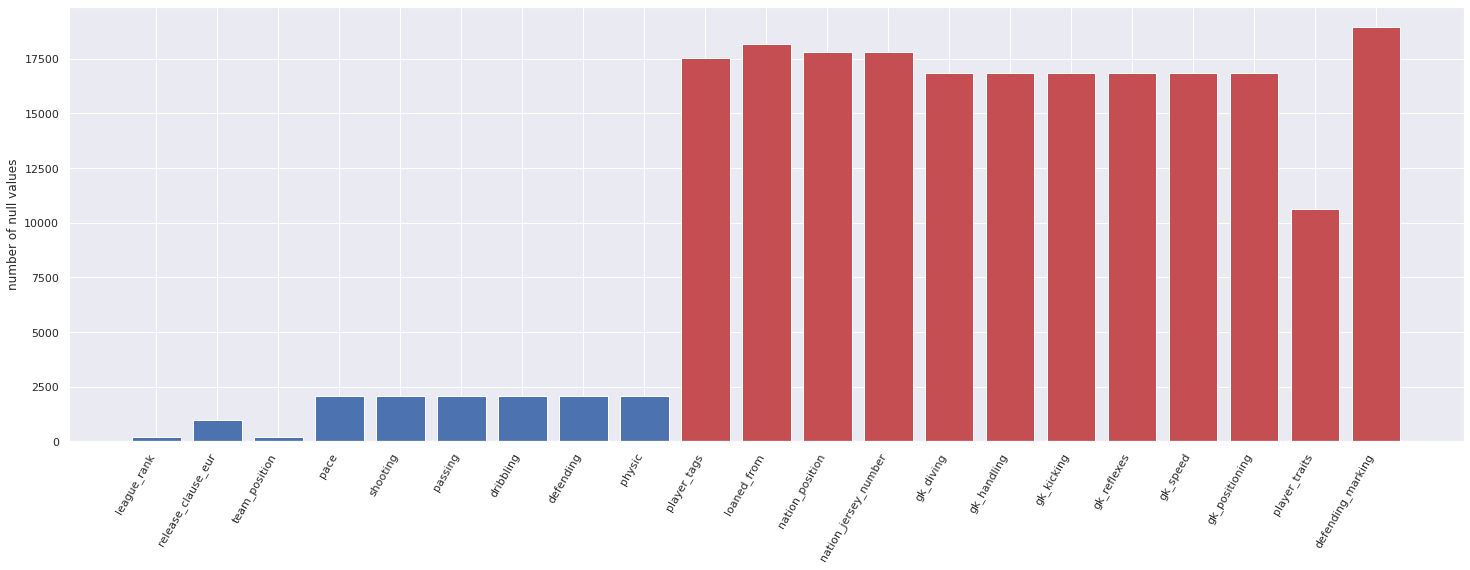

In [56]:
# 각 column들에 대한 null값 개수 그래프
# null 값들 개수 출력(0인 column 제외)
hist1_x = []
hist2_x = []
hist1_y = []
hist2_y = []
for column,n_null in zip(fifa1.columns,fifa1.isnull().sum()):
  if (n_null != 0):
    print(column + " : " + str(n_null))
    if (n_null > (18944/2)):
      hist1_x.append(column)
      hist1_y.append(n_null)
    else :
      hist2_x.append(column)
      hist2_y.append(n_null)

# 그래프 1
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (20,8)})
plt.bar(hist2_x,hist2_y,color='b')
plt.bar(hist1_x,hist1_y,color='r')
plt.ylabel("number of null values")
ax.set_xticklabels(hist2_x + hist1_x, rotation=60, ha='right')

null 값을 가지는 특성들을 자세히 보면  
일반 선수의 주요 특성 6가지인 pace, shooting, passing, dribbling,defending, physics 가 없는 선수는 2083명이고  골키퍼의 주요 특성 6가지인 gk_diving, gk_handling, gk_kicking, gk_reflexes, gk_speed, gk_positioning 가 없는 선수는 16861명 이였다.  
각 선수의 수를 더해보면 2083 + 16861 = 18944 로 전체 선수의 수였다.    
이 점으로 보아 선수의 포지션이 GK(골키퍼)이면 일반 선수들이 가지는 6가지 특성들이 없고 반대로 GK가 아니면 골키퍼 들이 가지는 6가지 특성이 없을수 없다는 것을 의심했다.

이것을 검증해보기 위해 각 포지션별 수를 출력해보니 null값을 가지는 수와 일치하는 것을 확인하였다.

In [57]:
print("team_positions가 GK인 선수의 수 : {}".format(len(fifa1[fifa1['player_positions'] == "GK"])))
print("team_positions가 GK가 아닌 선수의 수 : {}".format(len(fifa1[fifa1['player_positions'] != "GK"])))

team_positions가 GK인 선수의 수 : 2083
team_positions가 GK가 아닌 선수의 수 : 16861


null 값을 많이 포함하고 있는(절반 이상) columns을 학습에 참여시킬수 없기 때문에 골키퍼와  관련된 columns(gk_diving, gk_handling, gk_kicking, gk_reflexes, gk_speed, gk_positioning)을 포함하여 추가로 player_tag, loaned_from, nation_position, nation_jersey_number, player_traits, defending_marking columns도 제거하였다.  
또한 골키퍼에게 중요한 column를 삭제했기 때문에 해당 포지션에 대한 학습이 제대로 이루어 지지 않을것이라 판단해 모델의 정확성을 위해 골키퍼 포지션인 선수 정보를 모두 삭제하였다.

In [58]:
print(fifa1[(fifa1['pace']).isnull()]['team_position'])

2         GK
7         GK
9         GK
12        GK
16        GK
        ... 
18892    RES
18908    RES
18913    SUB
18924    SUB
18926    SUB
Name: team_position, Length: 2083, dtype: object


In [59]:
# 골키퍼 포지션 모두 삭제(pace 값이 없는 선수를 삭제)
print(len(fifa1[(fifa1['pace']).isnull()]['team_position']))
fifa1 = fifa1[fifa1['pace'].isnull() == False]
print(len(fifa1[(fifa1['pace']).isnull()]['team_position']))

# null 값 포함 columns 삭제
fifa2 = fifa1.drop([ 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning',
                    'player_tags','loaned_from','nation_position','nation_jersey_number','player_traits','defending_marking'    
],axis=1)
fifa2.head()

2083
0


,age,nationality,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_position,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,33,Argentina,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,138400000.0,CAM,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,35,Portugal,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,75900000.0,LS,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
3,31,Poland,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,132000000.0,ST,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,28,Brazil,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,166500000.0,LW,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11
5,29,Belgium,1.0,91,91,87000000,370000,"CAM, CM",Right,4,5,4,High/High,161000000.0,RCM,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,92,77,76,78,91,76,91,63,89,74,91,76,66,88,94,84,91,65,53,15,13,5,10,13


다시한번 null 값들의 개수에 대해 그래프를 그려보았을때,일부 null 값들을 가진 columns가 사라진것을 확인할수 있다.

null 값을 가지고 있는 columns 
league_rank : 195
release_clause_eur : 902
team_position : 195


Text(0.5, 1.0, 'columns that have any null values')

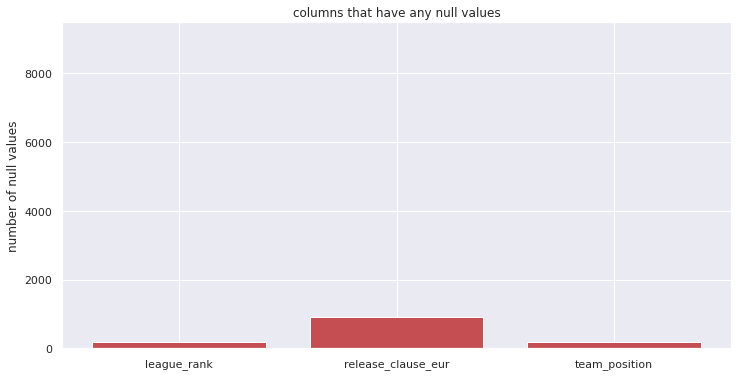

In [63]:
# 각 column들에 대한 null값 개수 그래프
# null 값들 개수 출력(0인 column 제외)
print("null 값을 가지고 있는 columns ")
hist_x = []
hist_y = []
for column,n_null in zip(fifa2.columns,fifa2.isnull().sum()):
  if (n_null != 0):
    print(column + " : " + str(n_null))
    hist_x.append(column)
    hist_y.append(n_null)

# 그래프
sns.set(rc={'figure.figsize': (12,6)})
plt.ylim([0,9472])
plt.bar(hist_x,hist_y,color='r')
plt.ylabel("number of null values")
plt.title("columns that have any null values")

## 2-6. 결측값 다루기
남은 columns 중 league_rank, team_position이 없는 선수의 수는 195로 동일했다. 이것을 통해 현재 팀에 소속 되어 있지 않은 선수가 195명이 있다는 것을 유추할수 있었고 이것을 확인해 보았다.

In [64]:
null_1 = fifa2[fifa2['league_rank'].isnull()].index.tolist()
null_2 = fifa2[fifa2['team_position'].isnull()].index.tolist()

if null_1 == null_2:
  print("같은 선수")
else: 
  print("다른 선수")

같은 선수


코드를 통해 각 columns에서 나타내는 null 값이 같은 195명을 나타내는 것을 알수 있었다.     
해당 195명을 제거함으로서 column들이 null 값을 가질수 없게 하였다.

In [65]:
fifa3 = fifa2[fifa2['league_rank'].isnull() == False]
print(len(fifa3[(fifa3['league_rank']).isnull()]))

0


release_clause_eur은 선수를 해당 구단과 협의없이 구매할 수 있는 금액인 바이아웃을 의미한다. 선수의 가치를 매길때 중요한 항목이기 때문에 null값이 있어 drop 하는 것이 아니라 값을 대체하여 학습에 사용하려 했다. 

아래는 해당 column을 describe 함수에 적용했을때의 결과이다. 이 값이 어느정도 레벨의 선수의 값인지 확인하기 위해 해당 relase_clause_eur을 가지는 선수의 정보를 검색했다.

In [66]:
fifa3["release_clause_eur"].describe()

count    1.595900e+04
mean     4.433379e+06
std      1.012464e+07
min      3.100000e+04
25%      5.630000e+05
50%      1.200000e+06
75%      3.500000e+06
max      2.031000e+08
Name: release_clause_eur, dtype: float64

정확한 비교를 위해 null 값이 있는 선수들만을 모아 그래프로 Overall 분포도를 나타내었다.

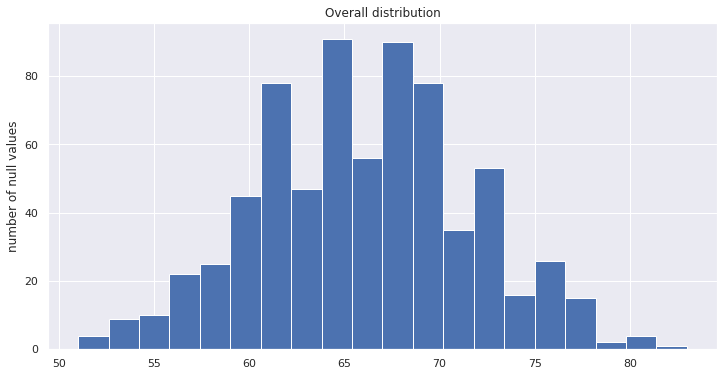

,age,league_rank,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,707.000000,707.000000,707.000000,707.000000,7.070000e+02,707.000000,707.000000,707.000000,707.000000,0.0,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.00000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,23.538897,1.478076,65.937765,73.514851,1.911499e+06,7178.359264,1.052334,3.016973,2.579915,NaN,68.787836,53.384724,57.029703,63.550212,49.224894,63.046676,53.916549,51.752475,56.427157,62.752475,46.902405,62.308345,51.643564,45.432815,55.18529,64.063649,68.758133,68.826025,66.861386,61.775106,66.956153,59.670438,64.229137,64.657709,64.297030,51.674682,57.513437,47.240453,56.396040,55.620934,52.258840,59.823197,49.125884,47.094767,10.209335,10.277228,10.404526,10.190948,10.175389
std,4.184092,0.826620,5.590266,5.214193,2.856478e+06,11839.032164,0.258191,0.613581,0.609457,NaN,10.733059,13.266785,9.350916,8.918816,16.572668,9.554485,13.642962,15.723157,11.450163,8.110225,13.747020,10.832277,14.347675,14.469934,11.87367,8.308170,11.053670,11.033531,11.486438,7.427386,11.372002,12.413566,11.467338,10.344708,12.629029,14.725976,14.083453,19.331868,13.348728,11.876991,12.021324,8.823008,19.488131,19.468819,2.914995,2.930175,2.967316,2.985618,3.071447
min,17.000000,1.000000,51.000000,56.000000,0.000000e+00,500.000000,1.000000,1.000000,2.000000,NaN,25.000000,22.000000,28.000000,30.000000,18.000000,36.000000,14.000000,10.000000,23.000000,34.000000,16.000000,15.000000,16.000000,19.000000,20.00000,32.000000,24.000000,25.000000,27.000000,36.000000,31.000000,22.000000,30.000000,21.000000,29.000000,13.000000,23.000000,10.000000,13.000000,15.000000,22.000000,35.000000,10.000000,10.000000,4.000000,4.000000,5.000000,4.000000,3.000000
25%,21.000000,1.000000,62.000000,70.000000,4.500000e+05,2000.000000,1.000000,3.000000,2.000000,NaN,63.000000,44.000000,50.500000,59.000000,33.000000,57.000000,44.000000,39.000000,48.000000,58.000000,36.000000,57.000000,40.500000,34.000000,48.00000,59.000000,63.000000,64.000000,60.500000,57.000000,61.000000,52.000000,58.000000,58.000000,57.000000,42.000000,47.500000,28.000000,50.000000,48.000000,43.000000,54.000000,30.500000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,23.000000,1.000000,66.000000,74.000000,8.500000e+05,3000.000000,1.000000,3.000000,3.000000,NaN,70.000000,56.000000,58.000000,65.000000,53.000000,64.000000,56.000000,55.000000,58.000000,63.000000,47.000000,64.000000,52.000000,43.000000,57.00000,65.000000,69.000000,69.000000,68.000000,62.000000,68.000000,61.000000,65.000000,65.000000,65.000000,54.000000,59.000000,54.000000,59.000000,57.000000,53.000000,60.000000,56.000000,53.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,26.000000,2.000000,70.000000,77.000000,1.850000e+06,8000.000000,1.000000,3.000000,3.000000,NaN,76.000000,63.000000,63.000000,70.000000,63.000000,70.000000,65.000000,64.500000,65.000000,68.000000,57.000000,70.000000,63.000000,5

In [67]:
# Overall 분포 그래프
sns.set(rc={'figure.figsize': (12,6)})
plt.hist(fifa3[fifa3['release_clause_eur'].isnull()]['overall'],bins=20)
plt.ylabel("number of null values")
plt.title("Overall distribution")
plt.show()

fifa3[fifa3['release_clause_eur'].isnull()].describe()

null값을 가지는 선수들만을 모아보니 다양한 overall(정답 label)을 가진 선수들이 있고 이 분포가 전체 데이터셋의 Overall 분포와 유사함을 알수 있엇다. 그러므로 해당 column에 있는 null 값을 평균값으로 대체하였다.

In [68]:
# null 값 대체
replaced_value = float(round(fifa3['release_clause_eur'].mean()))
print(replaced_value)
fifa3['release_clause_eur'] = \
  fifa3['release_clause_eur'].replace(np.nan,replaced_value)

fifa3[fifa3['release_clause_eur'].isnull()]

4433379.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,age,nationality,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_position,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes


## 2-7. 나머지 column 처리
다른 columns에 대해서는 학습을 위해 아래와 같이 전처리하였다. 회귀모델에서 문자그대로 입력을 넣을 수 없기 때문에 str value를 numeric value로 대체하는 방향으로 진행하였다.

*   team_position은 제거, player_positions을 한가지로 통일(player_position에 여러개의 포지션이 있다면 이 중 제일 처음 포지션을 선택)
*   상위 50개의 nationality에 속하는 선수면 1, 아니면 0으로 변환
*   preferred_foot(왼발,오른발)은 (0,1)로 대체
*   work_rate 는 (공격 성향/수비 성향)으로 구성되기 때문에 이것을 두개의 columns 으로 분리
*   team_position을 분류하여 numeric value로 변환






In [69]:
fifa3.head(-10)

,age,nationality,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_position,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,33,Argentina,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,138400000.0,CAM,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8
1,35,Portugal,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,75900000.0,LS,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11
3,31,Poland,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,132000000.0,ST,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10
4,28,Brazil,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,166500000.0,LW,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11
5,29,Belgium,1.0,91,91,87000000,370000,"CAM, CM",Right,4,5,4,High/High,161000000.0,RCM,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,92,77,76,78,91,76,91,63,89,74,91,76,66,88,94,84,91,65,53,15,13,5,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18929,17,England,4.0,47,67,60000,500,CM,Right,1,2,2,Medium/Medium,165000.0,SUB,64.0,40.0,48.0,49.0,35.0,45.0,38,42,40,56,35,46,40,35,50,48,63,64,61,51,66,48,58,43,47,30,40,23,47,47,36,38,44,40,12,10,9,6,8
18930,18,England,1.0,47,65,60000,500,CM,Right,1,2,2,Medium/Medium,131000.0,SUB,63.0,39.0,44.0,46.0,40.0,53.0,30,34,43,54,39,43,39,31,47,47,59,66,51,47,67,45,52,50,54,41,56,42,47,43,42,43,43,45,13,12,6,6,11
18931,19,Bolivia,1.0,47,63,60000,500,CDM,Right,1,3,2,Medium/Medium,167000.0,RES,57.0,32.0,43.0,48.0,44.0,49.0,32,27,48,52,32,45,31,32,47,43,55,59,59,50,75,41,55,47,47,33,57,45,30,39,35,36,41,45,10,8,15,9,14
18932,19,Bolivia,1.0,47,62,60000,500,CM,Right,1,3,2,Low/Medium,167000.0,RES,67.0,35.0,47.0,46.0,40.0,56.0,40,26,48,52,37,44,37,39,54,41,64,69,51,53,75,51,59,65,49,35,59,39,47,42,35,43,35,47,12,11,10,8,11


In [70]:
Top50_nationality = fifa.nationality.value_counts()[0:50].index.tolist()

# 전처리 함수
def change_nation(df):
  if (df["nationality"] in Top50_nationality):
    return 1
  else: 
    return 0

def change_foot(df):
  if (df["preferred_foot"] == "Left"):
    return 0
  else:
    return 1

def change_work_rate(df):
  rate = df.work_rate.str.split('/').str
  df["attack_rate"] = rate[0]
  df["defense_rate"] = rate[1]
  df.drop(['work_rate'],axis=1,inplace=True)

fifa_final = fifa3.copy()

# 포지션
fifa_final.drop(["team_position"],axis=1,inplace=True)
fifa_final["player_positions"] = fifa_final["player_positions"].str.split(",").str[0]
# 국가
fifa_final["nationality"] = fifa_final.apply(change_nation, axis=1)
# 선호하는 발 
fifa_final["preferred_foot"] = fifa_final.apply(change_foot, axis=1)
change_work_rate(fifa_final)

# 인텍스 재설정
fifa_final.reset_index(drop=True,inplace=True)
fifa_final.head(-10)

,age,nationality,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,attack_rate,defense_rate
0,33,1,1.0,93,93,67500000,560000,RW,0,5,4,4,138400000.0,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8,Medium,Low
1,35,1,1.0,92,92,46000000,220000,ST,1,5,4,5,75900000.0,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11,High,Low
2,31,1,1.0,91,91,80000000,240000,ST,1,4,4,4,132000000.0,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10,High,Medium
3,28,1,1.0,91,91,90000000,270000,LW,1,5,5,5,166500000.0,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11,High,Medium
4,29,1,1.0,91,91,87000000,370000,CAM,1,4,5,4,161000000.0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,92,77,76,78,91,76,91,63,89,74,91,76,66,88,94,84,91,65,53,15,13,5,10,13,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,17,1,4.0,47,67,60000,500,CM,1,1,2,2,165000.0,64.0,40.0,48.0,49.0,35.0,45.0,38,42,40,56,35,46,40,35,50,48,63,64,61,51,66,48,58,43,47,30,40,23,47,47,36,38,44,40,12,10,9,6,8,Medium,Medium
16652,18,1,1.0,47,65,60000,500,CM,1,1,2,2,131000.0,63.0,39.0,44.0,46.0,40.0,53.0,30,34,43,54,39,43,39,31,47,47,59,66,51,47,67,45,52,50,54,41,56,42,47,43,42,43,43,45,13,12,6,6,11,Medium,Medium
16653,19,1,1.0,47,63,60000,500,CDM,1,1,3,2,167000.0,57.0,32.0,43.0,48.0,44.0,49.0,32,27,48,52,32,45,31,32,47,43,55,59,59,50,75,41,55,47,47,33,57,45,30,39,35,36,41,45,10,8,15,9,14,Medium,Medium
16654,19,1,1.0,47,62,60000,500,CM,1,1,3,2,167000.0,67.0,35.0,47.0,46.0,40.0,56.0,40,26,48,52,37,44,37,39,54,41,64,69,51,53,75,51,59,65,49,35,59,39,47,42,35,43,35,47,12,11,10,8,11,Low,Medium


 # 3. 분석
 ## 3-1. 두번째 correlation heatmap 분석
 다시 한번 상관 분석 heatmap 실행하였다.
 간략한 분석을 위해 세부능력치는 제외하고 19번째 column까지의 능력치로만 분석하였다.

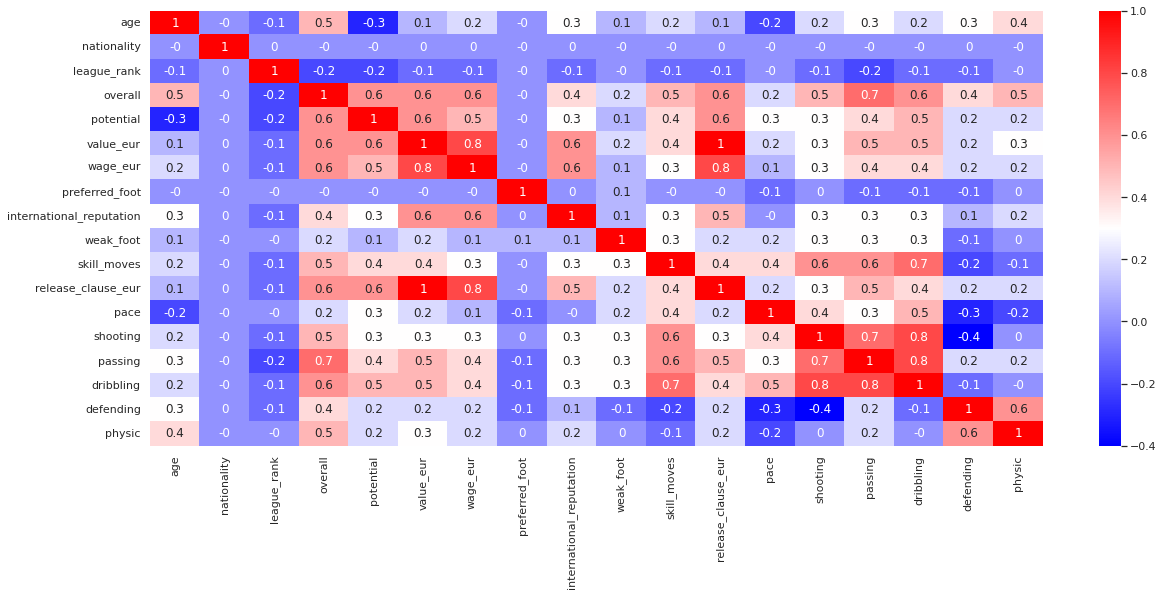

In [71]:
correlation_matrix = fifa_final.iloc[:,:19].corr().round(1)
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(data=correlation_matrix, annot=True, cmap="bwr")

### 상관관계 분석을 통한 결과로 크게 4가지 사실을 알수 있었다. 

1.   선수의 가치와 관련된 항목들의 상관계수가 높았다. 선수 가치(value_eur), 임금(wage_eur),바이아웃(release_clause_eur) 은 큰 연관성을 보였다. 선수의 가치가 높으면 그에 따른 바이아웃과 연봉도 같이 올라가는 점을 반영했다고 생각한다. 
2.   개인기 사용 레벨(skill_moves)와 드리블(dribbling)은 깊은 연관이 있었다. 실제로 개인기를 잘하는 선수가 드리블 능력도 좋다는 사실과 일치하는 점이다.
3.   정답 label로 선정한 overall에 가장 큰 상관관계에 있는 능력치는 패스(passing)이다. 그 외에 잠재력(potential),선수가치(value_eur) 등이 큰 영향을 주었다.
4.   슈팅(shooting), 패스(pass), 드리블링(dribbling) 3가지 능력치는 서로 큰 연관성을 가지고 있고 모두 overall에 많은 영향을 주고 있다. 


슈팅,패스, 드리블이 서로 어떤 연관성이 있고 overall에는 어느정도 영향을 미치는 지 알기 위해 추가적인 데이터 분석을 진행하였다.




##3-2. 슈팅, 패스, 드리블간의 관계
각 능력치들간의 관계 분석을 하기 위해 (슈팅,패스) (패스,드리블링) (드리블링,슈팅)으로 묶어 분포도로 나타내보았다. 
다른 조합에 비해 (패스,드리블링)의 조합이 좀 더 선형적인 관계를 나타내는 것을 통해 둘의 관계가 비례적이라는 것을 알수 있었다.

[Text(0.5, 1.0, 'dribbling and passing')]

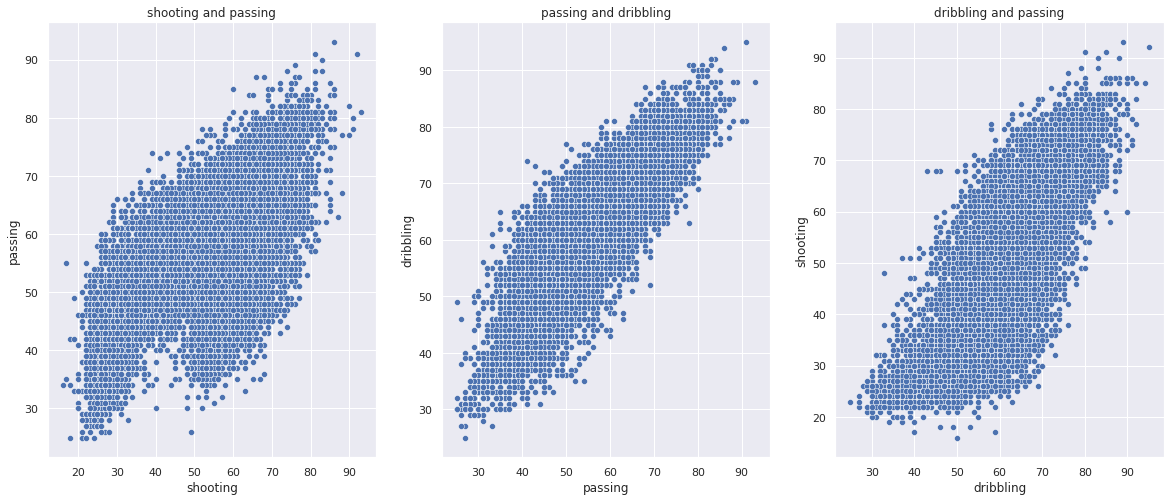

In [72]:
fig, ax = plt.subplots(ncols=3)
# 슈팅과 패스의 관계
fig1 = sns.scatterplot(x=fifa_final["shooting"],y=fifa_final["passing"],ax=ax[0])
fig1.set(title="shooting and passing")
# 패스와 드리블의 관계
fig2 = sns.scatterplot(x=fifa_final["passing"],y=fifa_final["dribbling"],ax=ax[1])
fig2.set(title="passing and dribbling")
# # 드리블과 슈팅의 관계
fig3 = sns.scatterplot(x=fifa_final["dribbling"],y=fifa_final["shooting"],ax=ax[2])
fig3.set(title="dribbling and passing")

##3-3. 슈팅,패스,드리블과 overall의 관계
이번에는 3가지의 능력치를 overall에 따른 분포도로 비교해보았다.  
correlation heatmap에서 패스 능력치와 overall간의 상관계수가 가장 높았던 것과 동일하게 이 그래프에서도 패스 능력치가 가장 선형에 가까운 분포도를 보였다.

[Text(0.5, 1.0, 'dribbling and overall')]

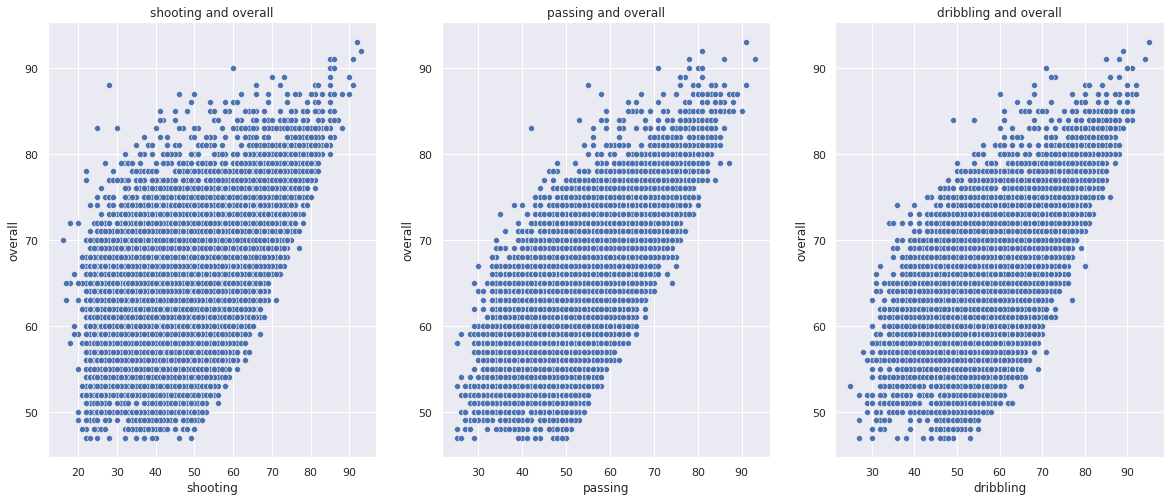

In [73]:
fig, ax = plt.subplots(ncols=3)
# 슈팅과 패스의 관계
fig1 = sns.scatterplot(x=fifa_final["shooting"],y=fifa_final["overall"],ax=ax[0])
fig1.set(title="shooting and overall")
# 패스와 드리블의 관계
fig2 = sns.scatterplot(x=fifa_final["passing"],y=fifa_final["overall"],ax=ax[1])
fig2.set(title="passing and overall")
# # 드리블과 슈팅의 관계
fig3 = sns.scatterplot(x=fifa_final["dribbling"],y=fifa_final["overall"],ax=ax[2])
fig3.set(title="dribbling and overall")

## 3-4. 포지션별 슈팅,패스,드리블과 overall의 관계
좀 더 유의미한 분석을 얻고자 위의 분석을 포지션별로 나누어 다시 진행하였다.

In [74]:
# 포지션 분리
fifa_final.player_positions.unique()
attack_position = np.array(['RW', 'ST', 'LW','CAM','CF'])
mid_position = (['CAM', 'CDM', 'CM', 'RM', 'LM'])
defend_position = (['CB', 'RB', 'LB', 'RWB', 'LWB'])

print("attaker positions : " + str(attack_position))
print("midfielder positions : " + str(mid_position))
print("defend positions : " + str(defend_position))
fifa_position = fifa_final.copy()

# 공격수 미드필더 수비수로 간략화된 포지션 추가
def attacker_midfieder_defender(df):
  if df["player_positions"] in attack_position:
    return "attk"
  elif df["player_positions"] in mid_position:
    return "mid"
  elif df["player_positions"] in defend_position:
    return "def" 

# 적용
fifa_position['position'] = fifa_position.apply(attacker_midfieder_defender,axis=1)

# 최종 전처리 데이터 저장
fifa_position.to_csv("/content/drive/MyDrive/3학년2학기/기계학습론/assignment1/final.csv",sep=',')

attaker positions : ['RW' 'ST' 'LW' 'CAM' 'CF']
midfielder positions : ['CAM', 'CDM', 'CM', 'RM', 'LM']
defend positions : ['CB', 'RB', 'LB', 'RWB', 'LWB']


 공격수의 overall은 슈팅과 드리블링,  
 미드필더의 overall은 패스와 드리블링에 영향을 크게 받는 것을 알수 있었다.  
 수비수의 overall은 공격수와 미드필더보다는 3가지 능력치에 적게 영향을 받는다는 것을 확인 할 수 있다.

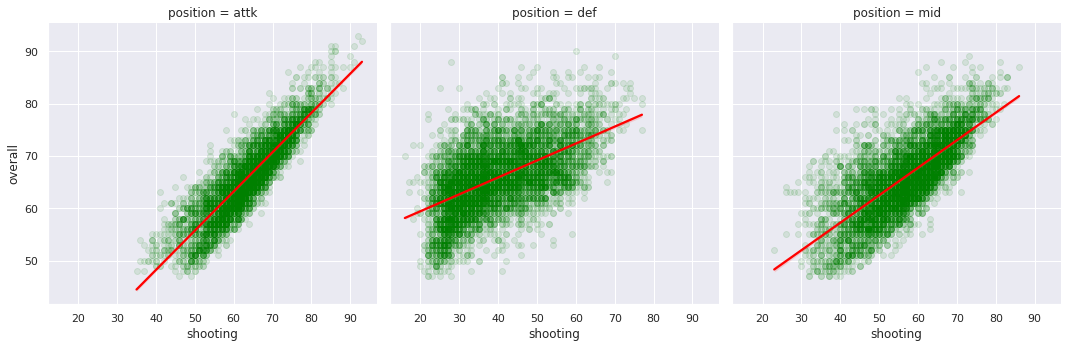

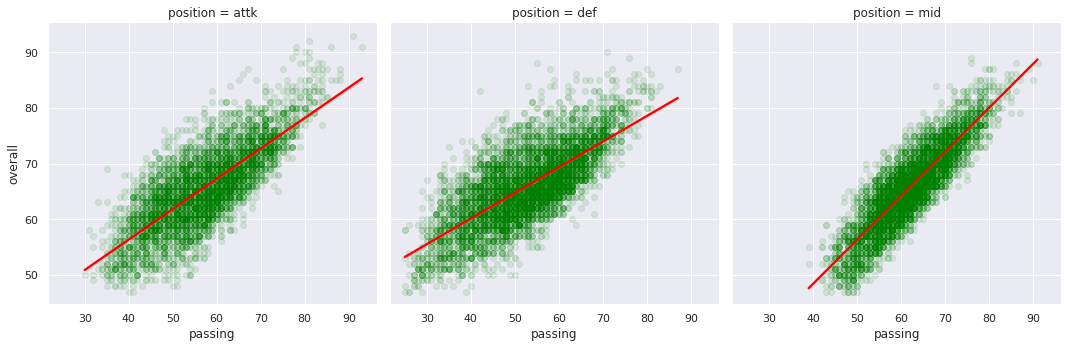

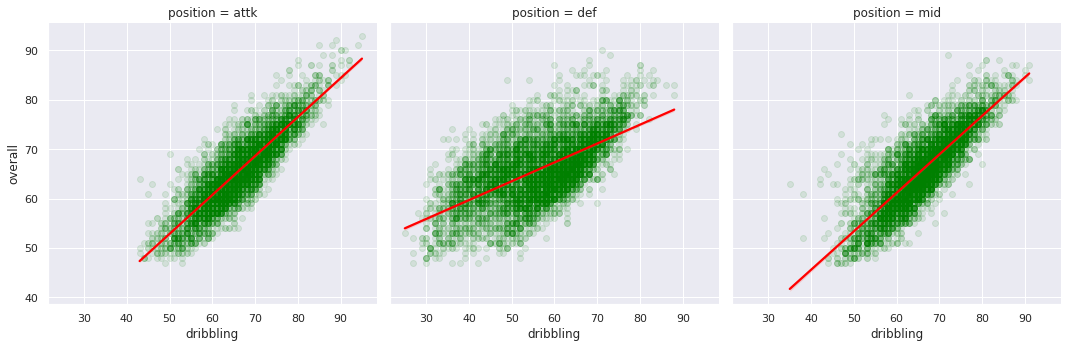

In [76]:
fig1 = sns.lmplot(x="shooting",y="overall", data = fifa_position,col = 'position',col_wrap=3,
           scatter_kws = {'alpha':0.1,'color':'green'}, line_kws={'color':'red'})
fig2 = sns.lmplot(x="passing",y="overall", data = fifa_position,col = 'position',col_wrap=3,
           scatter_kws = {'alpha':0.1,'color':'green'}, line_kws={'color':'red'})
fig3 = sns.lmplot(x="dribbling",y="overall", data = fifa_position,col = 'position',col_wrap=3,
           scatter_kws = {'alpha':0.1,'color':'green'}, line_kws={'color':'red'})

# 4. 회귀모델 학습
전처리한 데이터프레임에서 정답 label을 제외한 모든 columns을 이용해 overall을 예측하는 모델을 만들었다.

## 4-1. one - hot encoding 변경
학습데이터에 문자 데이터가 포함되면 안되기 때문에 get_dummies 함수를 통해 나머지 str value인 columns을 one-hot encoding으로 입력을 변환해주었다.


In [77]:
# 정답 label과 input 분리
y = fifa_final["overall"]
y = np.array(y).reshape(-1,1)


input = fifa_final.drop(["overall"],axis=1)
# one-hot-encoding 변환
input = pd.get_dummies(input)

print(input.shape)
print(y.shape)
input.head()

(16666, 71)
(16666, 1)


,age,nationality,league_rank,potential,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,player_positions_CAM,player_positions_CB,player_positions_CDM,player_positions_CF,player_positions_CM,player_positions_GK,player_positions_LB,player_positions_LM,player_positions_LW,player_positions_LWB,player_positions_RB,player_positions_RM,player_positions_RW,player_positions_RWB,player_positions_ST,attack_rate_High,attack_rate_Low,attack_rate_Medium,defense_rate_High,defense_rate_Low,defense_rate_Medium
0,33,1,1.0,93,67500000,560000,0,5,4,4,138400000.0,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,15,14,8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,35,1,1.0,92,46000000,220000,1,5,4,5,75900000.0,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,15,14,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
2,31,1,1.0,91,80000000,240000,1,4,4,4,132000000.0,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,12,8,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
3,28,1,1.0,91,90000000,270000,1,5,5,5,166500000.0,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,15,15,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,29,1,1.0,91,87000000,370000,1,4,5,4,161000000.0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,92,77,76,78,91,76,91,63,89,74,91,76,66,88,94,84,91,65,53,15,13,5,10,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## 4-2 : 학습과 오차측정
회귀 모델은 예측 오차가 존재하므로 이를 측정할 수 있는 방법으로 root mean squared error 방식을 사용하였다.  
학습은 standard scaler, minmax scaler를 포함하여 세가지로 진행하였다. feature scaling을 한다고 성능이 좋아지지는 않았다.
1. linear regression 
2. standard scler + linear regression
3. minmax scaler + linear regression

In [78]:
# training set 과 test set 분리
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

SS = StandardScaler()
MMS = MinMaxScaler()

input_1 = input.values

SS.fit(input_1)
MMS.fit(input_1)

input_ss = SS.transform(input_1)
input_mms = MMS.transform(input_1)

reg1 = LinearRegression()

for i in range(3):
  if i == 0:
      X = input
  elif i == 1:
      X = input_ss 
  else:
      X = input_mms

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=13)
  reg1.fit(X_train,y_train)

  # test set에 대한 오차
  y_test_predict = reg1.predict(X_test)
  rmse = (np.sqrt(mean_squared_error(y_test,y_test_predict)))

  print("performance")
  print("--------------------------------------")
  print('RMSE is ', rmse)
  print("")

performance
--------------------------------------
RMSE is  1.541813803658761

performance
--------------------------------------
RMSE is  1.5426232043816959

performance
--------------------------------------
RMSE is  1.5429205340083716



교차 검증을 하여 오차를 측정하는 KFold 방식을 추가해보았다. 

In [79]:
# linear_regression + KFold
reg2 = LinearRegression()
kfold = KFold(n_splits=10)
cv_rmse = []

SS = StandardScaler()

input_1 = input.values
SS.fit(input_1)
input_ss = SS.transform(input_1)

for train_idx, test_idx in kfold.split(input_1):
  X_train1, X_test1 = input_1[train_idx], input_1[test_idx]
  y_train1, y_test1 = y[train_idx], y[test_idx]

  reg2.fit(X_train1,y_train1)

  y_test_predict1 = reg2.predict(X_test1)
  rmse = (np.sqrt(mean_squared_error(y_test1,y_test_predict1))) 
  
  cv_rmse.append(rmse)

print("\nThe average performance for test set using KFold")
print("--------------------------------------")
print('RMSE is ', np.mean(cv_rmse))


The average performance for test set using KFold
--------------------------------------
RMSE is  2.205032763389081


## 4-3 : 결과 분석
다양한 방법을 시도하였지만 제일 rmse가 작은 기본 linear regression을 사용해  예측값과 실제 값의 그래프를 그려보았다.  
오차는 존재하지만 대체로 직선에 수렴하는 것을 보아 학습이 잘 되었다고 할 수 있다.   
데이터의 시각화를 통해 유추해볼수 있었던 것은 그래프의 오른쪽으로 갈수록 실제 값보다 예측값이 더 큰 경향이 있는데, 이는 게임안에서 선수를 평가하는 기준이 높은 overall을 가진 선수에게만 따로 적용되었다고 생각한다.

Text(0.5, 1.0, 'prediction of Overall')

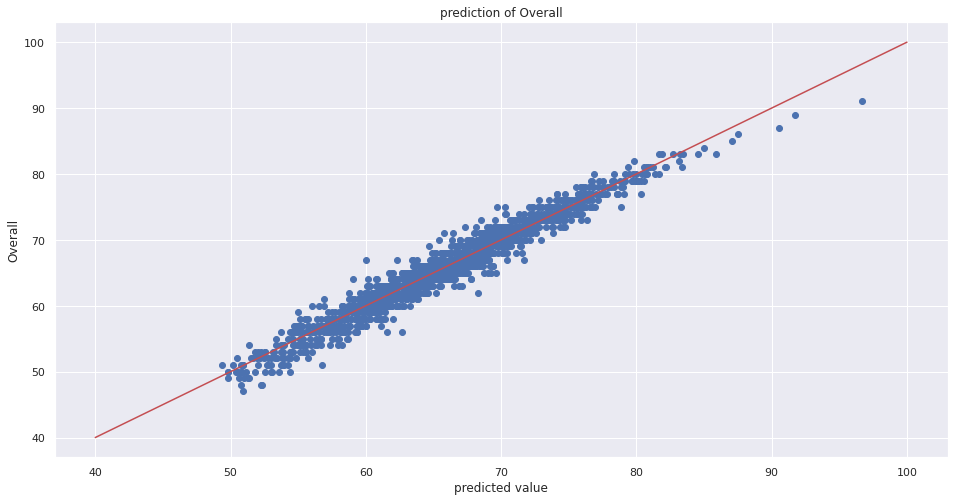

In [81]:
X_train, X_test, y_train, y_test = train_test_split(input,y,test_size=0.1,random_state=13)
reg1.fit(X_train,y_train)

plt.figure(figsize=(16,8))
plt.scatter(y_test_predict,y_test)
plt.plot([40,100],[40,100],'r')
plt.ylabel('Overall')
plt.xlabel('predicted value')
plt.title('prediction of Overall')

어떤 input feature가 영향을 많이 주었는지를 알아보기 위해 각각에 대한 weight를 eli5 패키지를 이용해 구해보았다.

In [82]:
!pip install eli5

In [83]:
import eli5
from eli5.sklearn import PermutationImportance

# 각 feature에 대한 weight를 계산
perm = PermutationImportance(reg1, random_state=13).fit(X_test,y_test)
# dataframe 변환
weights = eli5.formatters.as_dataframe.explain_weights_df(perm,feature_names=X_test.columns.tolist())
weights

,feature,weight,std
0,potential,0.168693,0.004212
1,age,0.131798,0.002088
2,movement_reactions,0.093889,0.002411
3,skill_ball_control,0.063748,0.001316
4,value_eur,0.041237,0.001033
...,...,...,...
66,passing,-0.000012,0.000016
67,attacking_volleys,-0.000013,0.000027
68,weak_foot,-0.000023,0.000010
69,power_long_shots,-0.000027,0.000022


weight를 그래프로 표현해보았을때 overall을 결정짓는 input features 는 potential, age, movement_reactions ... 순이었다.   
데이터 전처리,시각화 단계인 correlation matrix에서 높은 상관 계수를 가지는 features가 실제 높은 weight값을 가지는 것을 확인 할 수 있다. (potential, age , value_eur 은 상관 분석에서 overall에 대해 0.5 이상의 값이었다)  
그러나 상관 분석 값이 높을수록 더 큰 weight 값을 가지는 것은 아니므로, 실제 모델이 학습하는 weight는 상관 분석을 통해서만은 알 수 없었다.

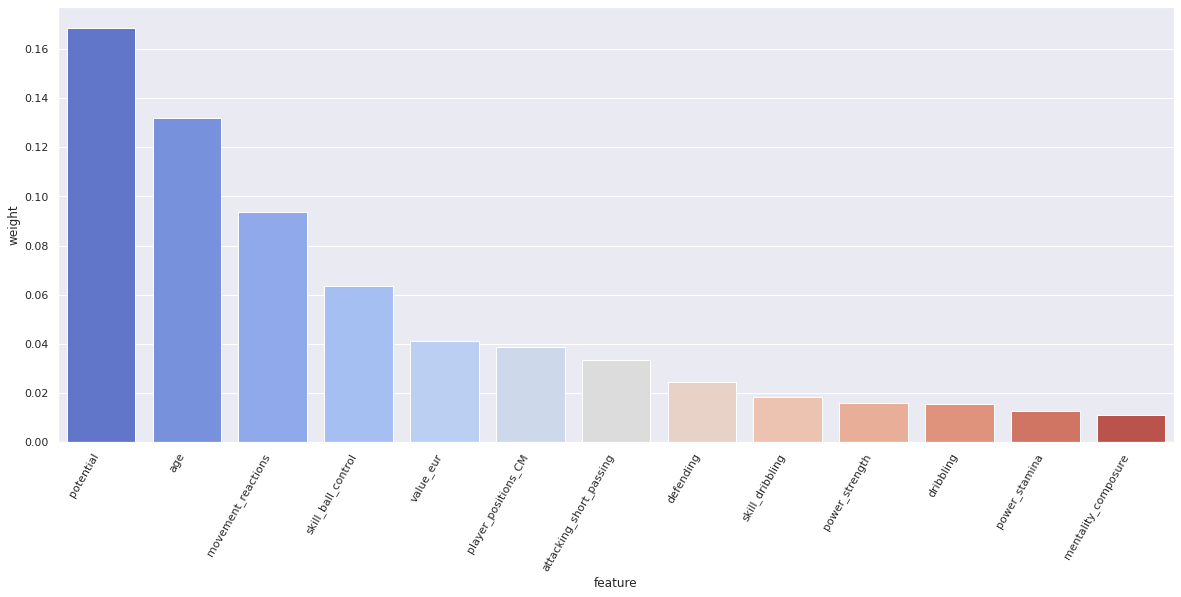

In [84]:
# weight가 0.01 이상만 그래프에 표시
weights = weights[weights["weight"] > 0.01]
# weights를 파이 그래프로 표현
fig, ax = plt.subplots()
ax.set_xticklabels(weights["feature"], rotation=60, ha='right')
sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x=weights["feature"], y=weights["weight"], data=weights["feature"], palette='coolwarm')